# **Проект "Прогнозирование оттока клиентов"**


## **Изучение данных**

Импортируем библиотеки:

In [1]:
!pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
import pandas as pd
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
RANDOM_STATE = 220523

Записываем данные в датафремы:

In [3]:
try:
    df_contract = pd.read_csv('/contract_new.csv')
    df_personal = pd.read_csv('/personal_new.csv')
    df_internet = pd.read_csv('/internet_new.csv')
    df_phone = pd.read_csv('/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

**Изучим датафрейм с информацией о договорах (df_contract)**

In [4]:
#выводим первые 5 строк
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
#выводим общую информацию
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
#проверяем дубликаты
df_contract.duplicated().sum()

0

<p>Пропусков и дубликатов нет, необходима замена типов данных. 
<p>Данные соеденены между собой столбцом "customerID" – уникальный айди клиента.
<p>BeginDate – необходимо привести к типу datetime.
<p>EndDate – длительность пользования клиентом услугами компании. Значение "No" означает, что клиент до сих пор пользуется услугами. Здесь можно сгенерировать дополнительный признак для модели. Для значений "No" можно установить свою уникальную дату и привести  к формату datetime.
<p>TotalCharges - всего потрачено денег на услуги, необходимо привести к числовому формату.

**Изучим датафрейм с информацией о персональных данных клиентов (df_personal)** 

In [7]:
#выводим первые 5 строк
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
#выводим общую информацию
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
#проверяем дубликаты
df_personal.duplicated().sum()

0

Пропусков и дубликатов нет, никаких действий не требуется

**Изучим датафрейм с информацией об интернет-услугах (df_internet)**

In [10]:
#выводим первые 5 строк
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
#выводим общую информацию
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
#проверяем дубликаты
df_internet.duplicated().sum()

0

Пропусков и дубликатов нет, данные есть не по всем клиентам.

**Изучим датафрейм с информацией об услугах телефонии (df_phone)**

In [13]:
#выводим первые 5 строк
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
#выводим общую информацию
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
#проверяем дубликаты
df_phone.duplicated().sum()

0

Пропусков и дубликатов нет, данные есть не по всем клиентам.

**Вывод**
<p>Загружены и изучены таблицы с данными:
<p>- `contract_new.csv` — информация о договоре;
<p>- `personal_new.csv` — персональные данные клиента;
<p>- `internet_new.csv` — информация об интернет-услугах;
<p>- `phone_new.csv` — информация об услугах телефонии.
<p>Всего в датафрейме 7043 клиента, из которых пользователей интернета - 5517, пользователей телефона - 6361.
<p>Пропусков и дубликатов нет.
<p>Данные соеденены между собой столбцом "customerID" – уникальный айди клиента.
<p>BeginDate – необходимо привести к типу datetime.
<p>EndDate – это целевой признак - длительность пользования клиентом услугами компании. Значение "No" означает, что клиент до сих пор пользуется услугами. Здесь можно сгенерировать дополнительный признак для модели. Для значений "No" можно установить свою уникальную дату и привести  к формату datetime.
<p>TotalCharges - всего потрачено денег на услуги, необходимо привести к числовому формату.
<p>После предобработки данных необходимо объединить все данные в одну таблицу, провести исследовательский анализ данных и дополнительное исследование на наличие пропусков и аномалий.


## Предобработка данных и исследовательский анализ данных

Добавим целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.

In [16]:
df_contract['Fact_leave'] = (df_contract['EndDate'] != 'No').astype(int)
#проверяем
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Заменим в EndDate значения "No" на дату 01.02.2020, т.к. из условия задачи мы знаем, что информация о договорах актуальна на 1 февраля 2020.

In [17]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])
print(df_contract[df_contract['EndDate'] == 'No'].shape[0])
#проверяем
df_contract.head(10)

0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


EndDate и BeginDate переведем в формат datetime

In [18]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format = '%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format = '%Y-%m-%d')

При переводе TotalCharges к числовому формату возникла ошибка. Возможно есть неявные пропуски. Смотрим значения полей

In [19]:
df_contract['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
1007.5      4
255.0       4
           ..
44.99       1
597.8       1
4685.06     1
551.57      1
136.15      1
Name: TotalCharges, Length: 6658, dtype: int64

Заменяем пропуски на нули и приводим в нужный формат

In [20]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)
df_contract['TotalCharges'].isnull().sum()

0

In [21]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('int')

In [22]:
#проверяем изменения
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   int64         
 8   Fact_leave        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 495.3+ KB


Объединим таблицы в один датафрейм

In [23]:
df = df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID') 

In [24]:
#устанавливаем индексом сustomerID
df = df.set_index('customerID')

Изучим объедененную таблицу

In [25]:
df.shape

(7043, 20)

In [26]:
df.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [27]:
df.describe()

,MonthlyCharges,TotalCharges,Fact_leave,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2114.859009,0.156325,0.162147
std,30.090047,2112.745015,0.363189,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.500000,0.000000,0.000000
50%,70.350000,1343.000000,0.000000,0.000000
75%,89.850000,3236.000000,0.000000,0.000000
max,118.750000,9221.000000,1.000000,1.000000


In [28]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   int64         
 7   Fact_leave        7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Пропуски в столбцах возможно означают, что эти услуги не подключены. Заменим пропуски на "No"

In [29]:
df=df.fillna('No')

In [30]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   int64         
 7   Fact_leave        7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

Добавим столбец количество дней пользования услугами

In [31]:
df['Days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [32]:
#проверяем
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071,0,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226,0,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960,0,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353,0,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


<b/>Вывод</b>
<p>Добавили целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.   
<p>BeginDate и EndDate привели к формату datetime.
<p>В EndDate заменили значения "No" на актуальную дату 01.02.2020
<p>TotalCharges - заменили неявные пропуски и привели к числовому формату.
<p>Объеденили все данные в одну таблицу. Пропуски в столбцах услуг заменили пропуски на "No".
<p>Добавили дополнительный столбец Days - количество дней пользования услугами.
 

# Исследуем данные

Анализируем данные среди ушедших и оставшихся клиентов

In [33]:
#обозначим категориальные столбцы
cat_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

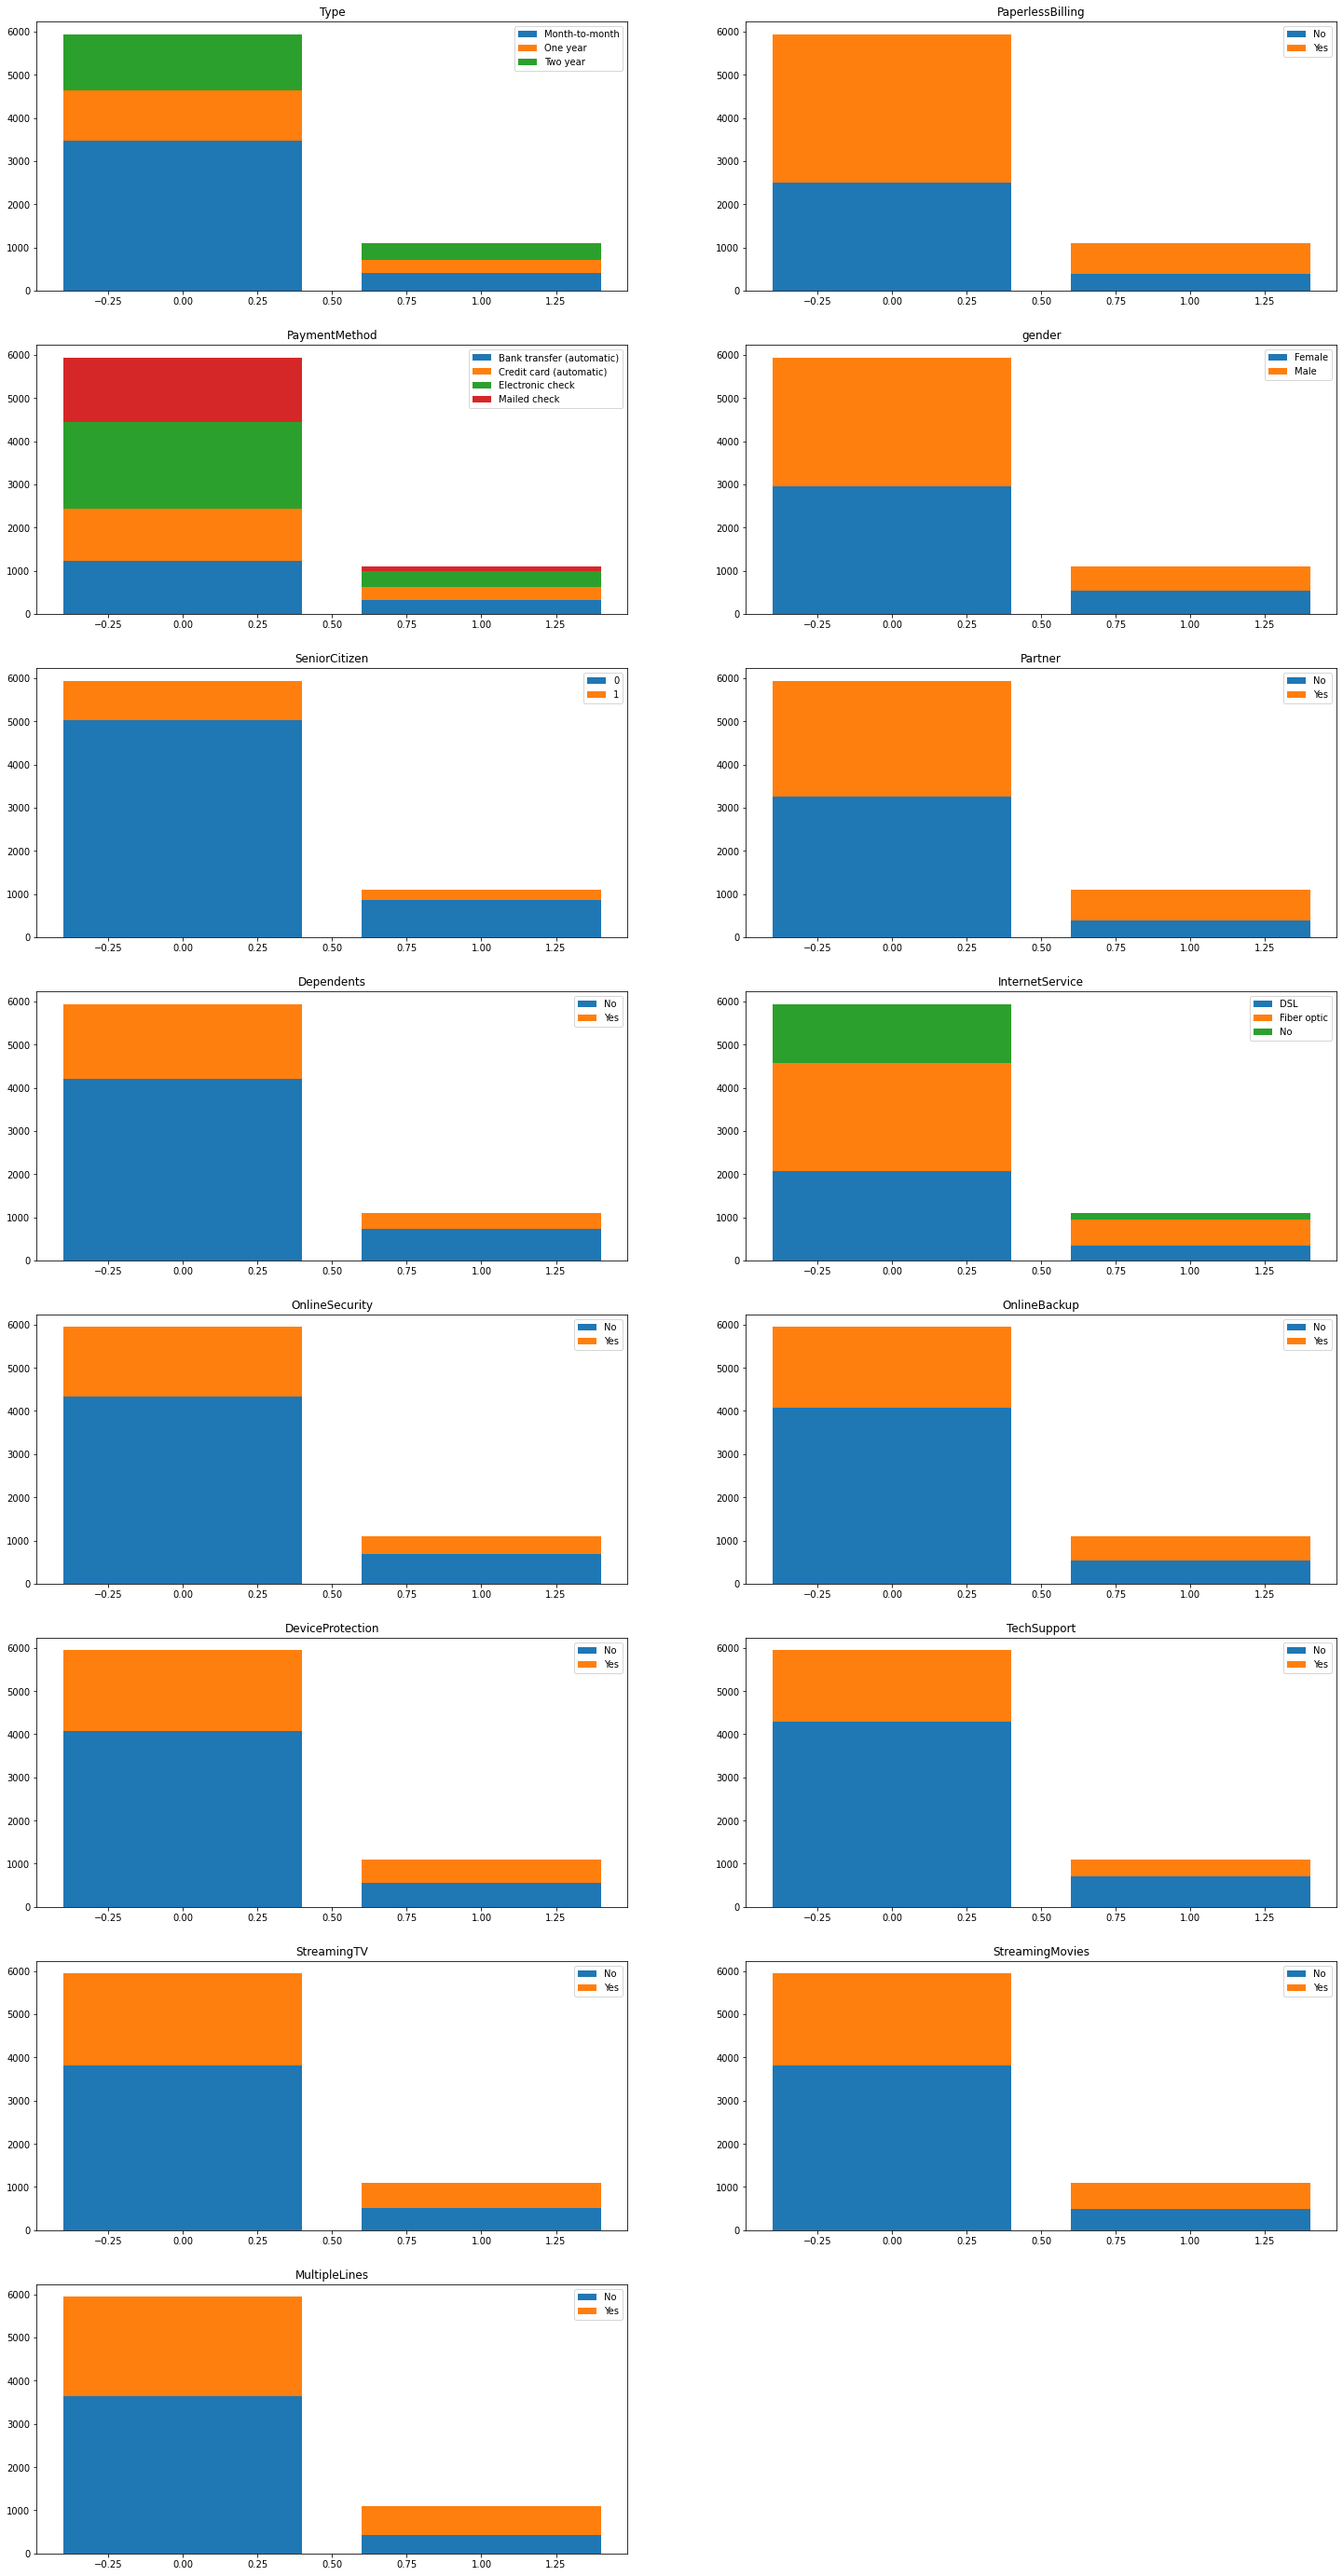

In [34]:
cols = 2
rows = int(np.ceil(len(cat_columns) / cols))

plt.figure(figsize=(25, 50))
for idx, column in enumerate(cat_columns):
    df_group = df.groupby([column, 'Fact_leave'])['Fact_leave'].count()
    df_group = df_group.unstack()
    ax = plt.subplot(rows, cols, idx+1)
    ax.bar(df_group.T.index, df_group.T[df_group.T.columns[0]], label=df_group.T.columns[0])
    bottom = np.array(df_group.T[df_group.T.columns[0]])
    for color_idx, value in enumerate(df_group.T.columns[1:]): 
        ax.bar(df_group.T.index, df_group.T[value], bottom=bottom, label=value)
        bottom += np.array(df_group.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

<p>Распределения по полу идентичные. Пол не влияет на факт ухода.
<p>Пенсионный статус не сильно влияет на факт ухода.
<p>Пенсионный статус не сильно влияет на факт ухода.
<p>У большинства ушедших клиентов спруга/супруги нет.
<p>Наличие иждевенцев не сильно влияет на факт ухода клиентов.
<p>Способы оплаты у ушедших клиентов практически одинаковые. Самый популярный способ оплаты у оставшихся - помесячный;
<p>Ушедшие клиенты чаще всего использовали электронные чеки и электронную оплату.
<p>По гендерному признаку различий между ушедшишми и оставшимися клиентам нет.
<p>У большинства клиентов нет пенсионного статуса и иждевенцов.
<p>Оптоволокно самый распространенный способ подключения;
<p>Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не подключены у многих клиентов.    

Смотрим величину платежей ушедших и оставшихся клиентов

In [35]:
#пишем функцию для анализа
def kdeplot(data, xlabel1='', figsize1=(10, 5), label1='', suptitle1='', ylabel1='', lg='', hue1=None):
    fig, ax = plt.subplots(figsize=figsize1)
    fig.suptitle(suptitle1, fontsize=13) 
    table = sns.kdeplot(data, color='blue', alpha=.4, shade=True, label=label1, hue=hue1) 
    table.grid(color = 'grey', linewidth = 1, linestyle=':')
    table.set_xlabel(xlabel1, fontsize=10)
    table.set_ylabel(ylabel1, fontsize=10) 
    return table

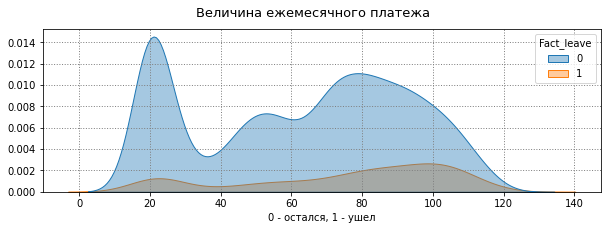

In [36]:
kdeplot(df['MonthlyCharges'], xlabel1='0 - остался, 1 - ушел', figsize1=(10, 3), 
        suptitle1='Величина ежемесячного платежа',
        ylabel1='', hue1=df['Fact_leave'])
plt.show()

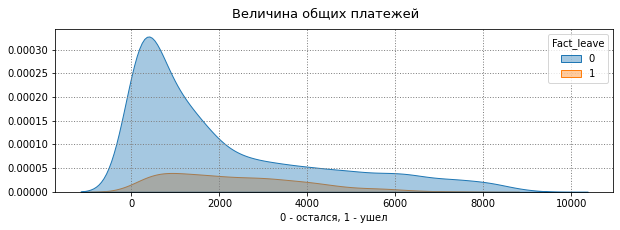

In [37]:
kdeplot(df['TotalCharges'], xlabel1='0 - остался, 1 - ушел', figsize1=(10, 3), 
        suptitle1='Величина общих платежей', 
        ylabel1='', hue1=df['Fact_leave'])
plt.show()

Распределение величины ежемесячного платежа у ушедших клиетов выше. Ушедшие клиенты платили больше.

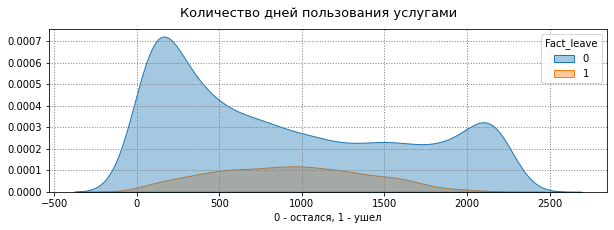

In [38]:
kdeplot(df['Days'], xlabel1='0 - остался, 1 - ушел', figsize1=(10, 3), 
        suptitle1='Количество дней пользования услугами', 
        ylabel1='', hue1=df['Fact_leave'])
plt.show()

Большинство ушедших клиентов пользовалиьс услугами от 1 года до 3 лет

## Обучение модели

Удаляем ненужные столбцы

In [39]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)

Веделяем признаки

In [40]:
target = df['Fact_leave'] 
features = df.drop(columns=['Fact_leave'])

Делим данные на обучающую и тестовую выбороки

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=.25, 
                                                                            random_state=RANDOM_STATE)

In [42]:
#проверяем
train_sample = features_train.shape[0] / features.shape[0]
test_sample = features_test.shape[0] / features.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


In [43]:
#выделяем категориальные признаки для модели CatBoost
cat_features = ['Type','PaperlessBilling','PaymentMethod', 
                'gender','Partner','Dependents','InternetService',
                'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
                'TechSupport','StreamingTV','StreamingMovies',  
                'MultipleLines']

Проводим масштабирование количественных признаков

In [44]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])

features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])

Кодируем категориальные признаки с помощью OneHotEncoder

In [45]:
#кодирование
features_train1 = features_train.copy()
features_test1 = features_test.copy()
features_train_ohe = pd.get_dummies(features_train1, drop_first=True)
features_test_ohe = pd.get_dummies(features_test1, drop_first=True)

In [46]:
#проверка на соответствие количества столбцов после кодирования
display(features_train_ohe.shape)
display(features_test_ohe.shape)

(5282, 22)

(1761, 22)

In [47]:
#проверка на соответствие категорий после кодирования
train_col = pd.DataFrame(features_train_ohe.columns.values.tolist()) 
test_col = pd.DataFrame(features_test_ohe.columns.values.tolist())
#фильтрация отсутствующих столбцов между train и test
missing = train_col[~train_col[0].isin(test_col[0])] 
print(missing)

Empty DataFrame
Columns: [0]
Index: []


In [48]:
#поэлементная проверка признаков после кодирования
features_train_ohe.columns == features_test_ohe.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Кодируем категориальные признаки с помощью OrdinalEncoder

In [49]:
#Кодируем категориальные признаки с помощью OrdinalEncoder
categor_features = ['Type','PaperlessBilling','PaymentMethod', 
                    'gender','Partner','Dependents','InternetService',
                    'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
                    'TechSupport','StreamingTV','StreamingMovies',  
                    'MultipleLines']

In [50]:
encoder = OrdinalEncoder()
features_train_oe = features_train.copy()
encoder.fit(features_train_oe[categor_features])
features_train_oe[categor_features] = encoder.transform(features_train_oe[categor_features])

Исследуем корреляцию

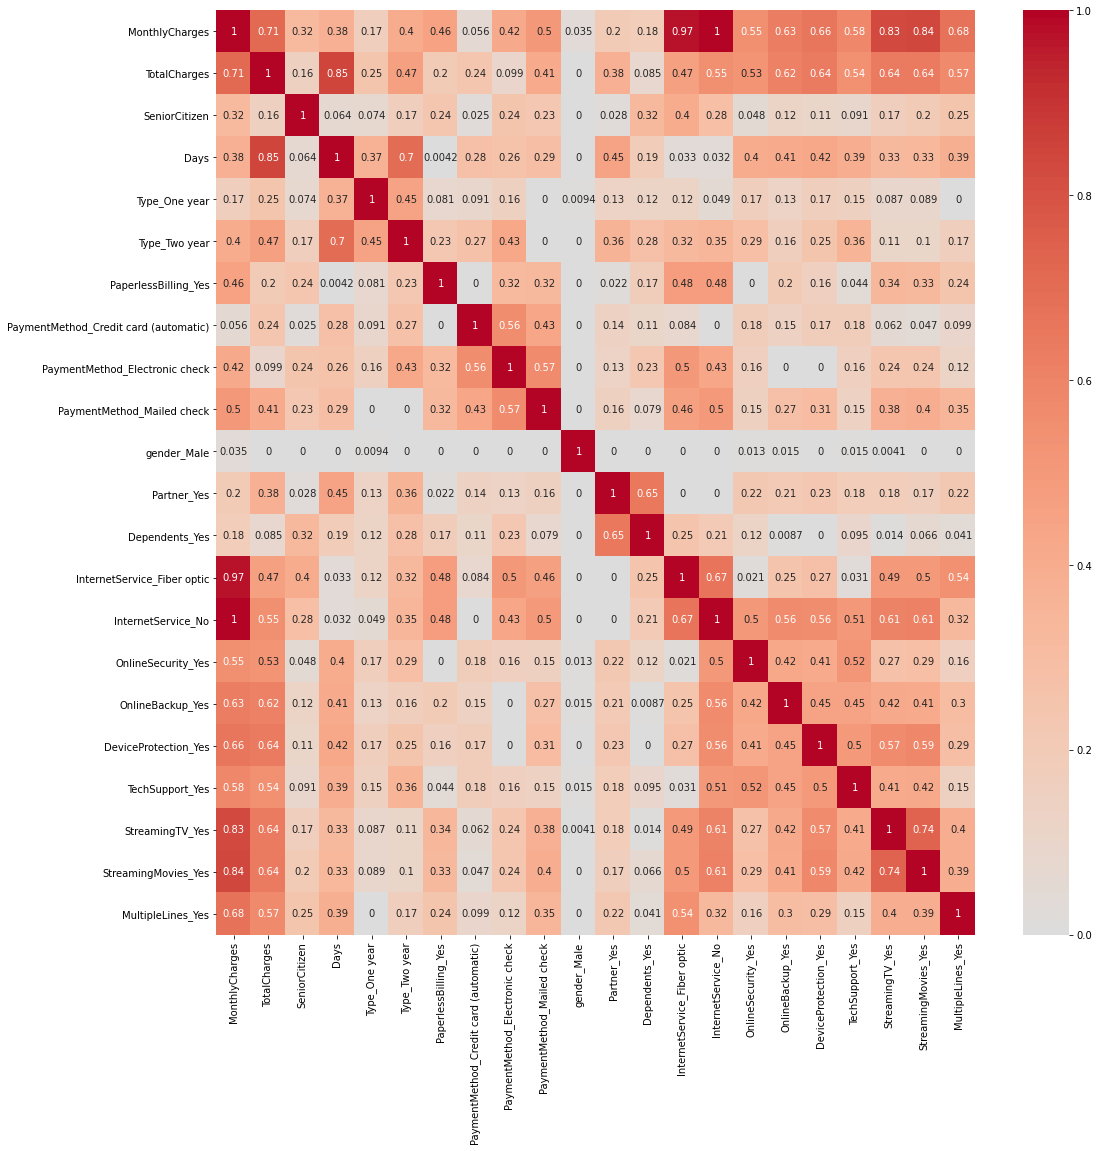

In [51]:
plt.figure(figsize=(17, 17))
sns.heatmap(features_train_ohe.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Days']), cmap='coolwarm', center=0, annot=True);

Сильно коррелирует созданный признак Days (количество дней пользования услугами) с TotalCharges (суммарными тратами). Получается, что признаки дублируют друг друга. Так как отношение ежемесячных трат и суммарных трат и является длительностью использования услуг.

In [52]:
#удалим признаки, создающие мультиколлинеарность
features_train_ohe = features_train_ohe.drop(['MonthlyCharges', 'Days'], axis=1)
features_test_ohe = features_test_ohe.drop(['MonthlyCharges', 'Days'], axis=1)

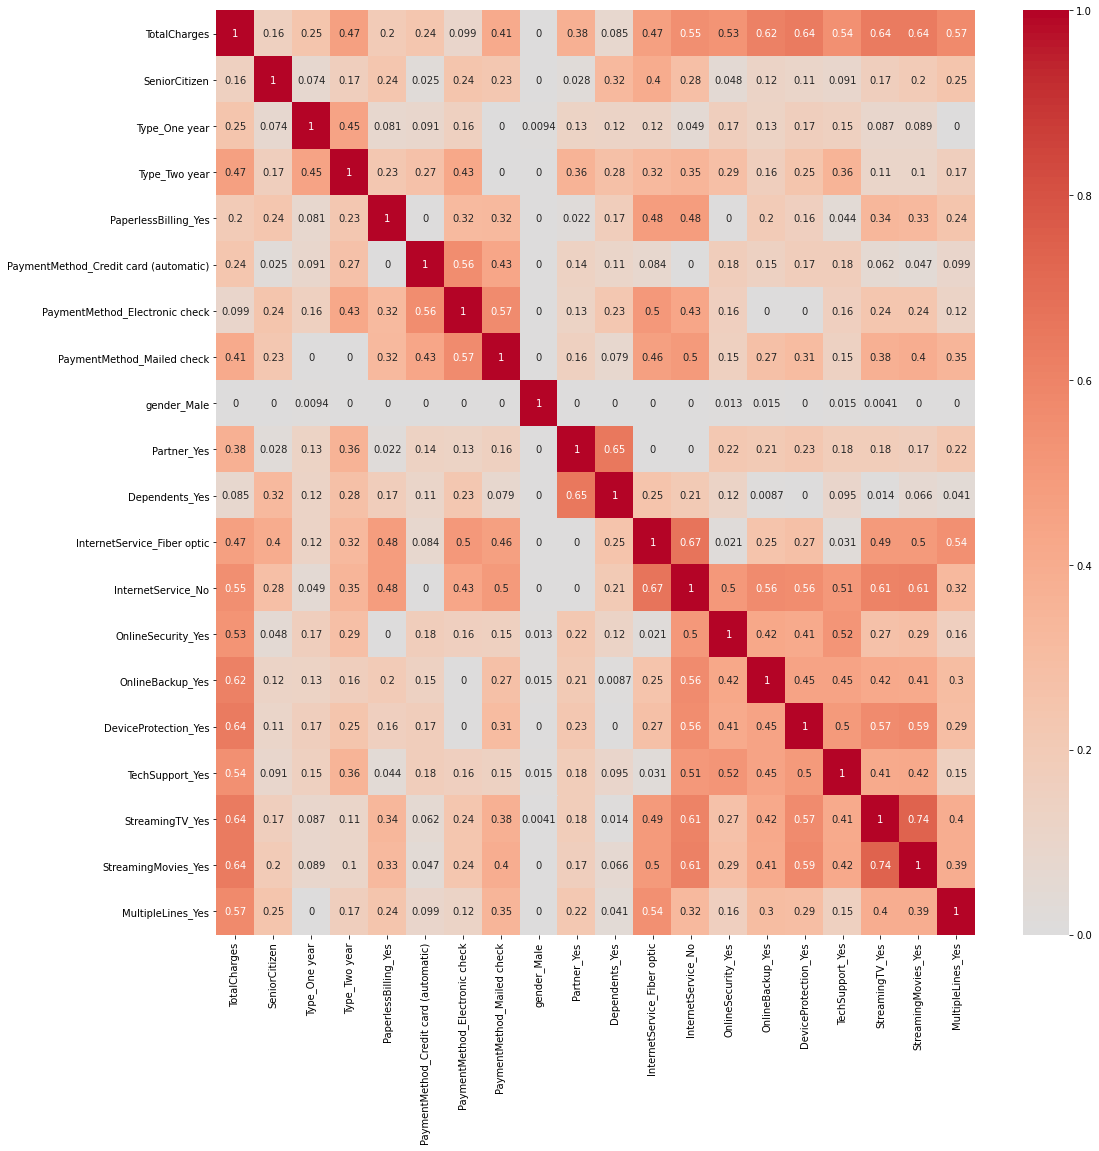

In [53]:
plt.figure(figsize=(17, 17))
sns.heatmap(features_train_ohe.phik_matrix(interval_cols=['TotalCharges']), cmap='coolwarm', center=0, annot=True);

<b/>LogisticRegression</b>

In [54]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE)
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'], 'C':[0.1, 1, 10]}]

grid_lr = GridSearchCV(model_lr, params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)
grid_lr.fit(features_train_ohe, target_train)

lr_best_params = grid_lr.best_params_
print(lr_best_params)
print('Среднее качество модели LogisticRegression на кросс-валидации:', grid_lr.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 1/3; 1/9] END ...................C=0.1, solver=newton-cg; total time=   1.4s
[CV 2/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 2/3; 1/9] END ...................C=0.1, solver=newton-cg; total time=   3.0s
[CV 3/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 3/3; 1/9] END ...................C=0.1, solver=newton-cg; total time=   2.8s
[CV 1/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 1/3; 2/9] END .......................C=0.1, solver=lbfgs; total time=   0.8s
[CV 2/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 2/3; 2/9] END .......................C=0.1, solver=lbfgs; total time=   1.0s
[CV 3/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 3/3; 2/9] END .......................C=0.1, s

<b/>RandomForestClassifier</b>

In [55]:
%%time 

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
params = [{'max_depth':[2,4,6], 'n_estimators': [10,50,100], 'class_weight':['balanced']}] 

grid_rfc = GridSearchCV(model_rfc, params, scoring='roc_auc', cv=3)
grid_rfc.fit(features_train_oe, target_train)

rfc_best_params = grid_rfc.best_params_
print(rfc_best_params)
print('Среднее качество модели LogisticRegression на кросс-валидации:', grid_rfc.best_score_)

{'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 100}
Среднее качество модели LogisticRegression на кросс-валидации: 0.8152660543308669
CPU times: user 5.69 s, sys: 0 ns, total: 5.69 s
Wall time: 6.11 s


<b/>CatBoostClassifier</b>

In [56]:
%%time

model_cat = CatBoostClassifier(verbose=False, iterations=250, random_state=RANDOM_STATE, cat_features=cat_features)
model_cat.fit(features_train, target_train)

model_cat_val = cross_val_score(model_cat, features_train, target_train, scoring='roc_auc', cv=3).mean() 
print('Среднее качество модели CatBoostClassifier на кросс-валидации:', model_cat_val)

Среднее качество модели CatBoostClassifier на кросс-валидации: 0.8483443412592723
CPU times: user 7.62 s, sys: 76.6 ms, total: 7.7 s
Wall time: 14.4 s


Сравниваем модели

In [57]:
index = ['LogisticRegression', 'RandomForestClassifier','CatBoostClassifier']
data = {'Среднее качество модели на кросс-валидации': [grid_lr.best_score_, grid_rfc.best_score_, model_cat_val]}
models_val = pd.DataFrame(data=data, index=index)
print(models_val)

                        Среднее качество модели на кросс-валидации
LogisticRegression                                        0.758296
RandomForestClassifier                                    0.815266
CatBoostClassifier                                        0.848344


Лучшая модель CatBoostClassifier с ROC-AUC score = 0,84. 

Оцениваем лучшую модель на тестовой выборке

In [58]:
predict_cat = model_cat.predict(features_test)
predict_roc_auc = model_cat.predict_proba(features_test)[:,1]
print('ROC-AUC score CatBoostClassifier на тестовой выборке равна ', roc_auc_score(target_test, predict_roc_auc))
print('Accuracy CatBoostClassifier на тестовой выборке равна ', accuracy_score(target_test, predict_cat))

ROC-AUC score CatBoostClassifier на тестовой выборке равна  0.8986212014686353
Accuracy CatBoostClassifier на тестовой выборке равна  0.9000567859170926


Анализ важности признаков

In [59]:
imp_fact = pd.DataFrame(model_cat.feature_importances_, index = features_test.columns, columns=['feature_importances'])
imp_fact = imp_fact.sort_values(by='feature_importances', ascending=False)
imp_fact

,feature_importances
Days,44.256841
Type,13.066793
TotalCharges,8.281751
MonthlyCharges,7.714121
PaymentMethod,6.525803
MultipleLines,4.183571
Partner,3.432969
InternetService,2.387991
OnlineBackup,1.984462
StreamingMovies,1.621105


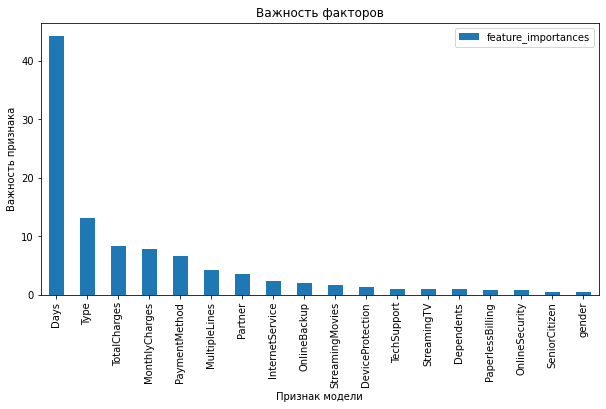

In [60]:
imp_fact.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.xlabel('Признак модели')
plt.ylabel('Важность признака')
plt.show()

Важные признаки Days, Type, TotalCharges и MonthlyCharges - количество дней пользования услугами, затраты клиентов и тип оплаты.

<b/>Вывод</b>
<p>Удалили ненужные столбцы
<p>Закодировали категориальные признаки с помощью One Hot Encoding
<p>Веделили признаки и разделили данные на обучающую и тестовую выбороки 
<p>Провелим масштабирование количественных признаков
<p>Сравнимли модели - лучшая модель CatBoostClassifier с ROC-AUC score на кросс-валидации = 0,84. На тестовой выборке модель показала ROC-AUC = 0,89, Accuracy = 0,90
<p>Анализ важности признаков показал, что Days, TotalCharges и MonthlyCharges наиболее важные признаки.

## Отчет

<p><b/>Целью исследования</b> было создать модель, которая на основании имеющихся даннных будет предсказывать уход клиента из компании.
<p>    
<p>Исходные данные состояли из 4 таблиц, полученных из разных источников:
<p>- `contract_new.csv` — информация о договоре;
<p>- `personal_new.csv` — персональные данные клиента;
<p>- `internet_new.csv` — информация об интернет-услугах;
<p>- `phone_new.csv` — информация об услугах телефонии.
<p>  
<p>Исходные 4 таблицы были соеденены между собой столбцом "customerID" в один датасет. Всего в датафрейме 7043 клиента, из которых пользователей интернета - 5517, пользователей телефона - 6361. Пропусков и дубликатов нет.
<p> 
<p><b/>В процессе были решены проблемы для предобработки данных:</b>
<p>Добавили целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.
<p>BeginDate и EndDate привели к формату datetime.
<p>В EndDate заменили значения "No" на актуальную дату 01.02.2020
<p>TotalCharges - заменили неявные пропуски и привели к числовому формату.
<p>Пропуски в столбцах услуг заменили пропуски на "No".
<p>Добавили дополнительный столбец Days - количество дней пользования услугами.  

  
<p>
<p><b/>В рамках исследовательского анализа данных были выявлены следующие закономерности:</b>    
<p>Распределения по полу идентичные среди клиентов. 
<p>Пол не влияет на факт ухода клиента из компании.
<p>Пенсионный статус не сильно влияет на факт ухода.
<p>У большинства ушедших клиентов спруга/супруги нет.
<p>Наличие иждевенцев не сильно влияет на факт ухода клиентов.
<p>Способы оплаты у ушедших клиентов практически одинаковые. Самый популярный способ оплаты у оставшихся - помесячный;
<p>Ушедшие клиенты чаще всего использовали электронные чеки и электронную оплату.
<p>По гендерному признаку различий между ушедшишми и оставшимися клиентам нет.
<p>У большинства клиентов нет пенсионного статуса и иждевенцов.
<p>Оптоволокно самый распространенный способ подключения.
<p>Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не подключены у многих клиентов. 
<p>

<p> <b/>При подготовки к обучению моделей были проведены слудующие шаги:</b> 
<p>Выборка была разделена на тренировочную и тестовую части в отношении 75%:25%.
<p>Провели кодирование категориальных признаков и масштабирование количественных признаков.
<p>Была исследована корреляция и удалены признаки, создающие мультиколлинеарность. 
<p>Выбор модели и подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV с кросс-валидацией. 
<p>Результаты работы моделей были проверены на тестовой выборке.
<p>

<p> <b/>Признаки, которые использовали для обучения моделей:</b> 
<p>- Days - Кол-во дней пользования услугами (не использовали для обучения модели LogisticRegression)
<p>- Type - Тип оплаты 
<p>- TotalCharges - Всего потрачено денег на услуги (не использовали для обучения модели LogisticRegression)
<p>- MonthlyCharges - Ежемесячные траты на услуги 
<p>- PaymentMethod - Способ оплаты 
<p>- MultipleLines - Возможность ведения параллельных линий во время звонка 
<p>- Partner - Наличие супруга(и) 
<p>- InternetService - Веб сервис 
<p>- OnlineBackup - Резервное копирование 
<p>- StreamingMovies - Фильмы 
<p>- DeviceProtection - Защита устройств 
<p>- TechSupport - Тех.поддержка 
<p>- StreamingTV - Телефидение 
<p>- Dependents - Наличие иждивенцев 
<p>- PaperlessBilling - Электронный платёжный документ 
<p>- OnlineSecurity - Антивирус 
<p>- SeniorCitizen - Наличие пенсионного статуса 
<p>- gender - Пол 

<p> <b/>В процессе исследования моделей были получены следующие результаты:</b>
<p>Для решения задачи классификации и предсказания факта ухода клиента были обучены 3 модели:
<p>- CatBoostClassifier
<p>- LogisticRegression
<p>- RandomForestClassifier
<p>Модели погказали следующие результаты на тренировочной выборке:
<p>AUC-ROC для LogisticRegression - 0,75
<p>AUC-ROC для RandomForestClassifier - 0,77
<p>AUC-ROC для CatBoostClassifier - 0,84

<p>Лучшей оказалась модель CatBoostClassifier с гиперпараметрами - {verbose=False, iterations=250, random_state=RANDOM_STATE} с AUC-ROC на тестовой выборке - 0.89 и accuracy на тестовой выборке - 0.90.
<p>    

<p><b/>Анализ важности признаков лучшей модели показал:</b> 
<p>Наиболее важные признаки -  Days, TotalCharges, MonthlyCharges и Type.

| Название признака | Расшифровка | Важность для модели, % |
| --- | --- | --- |
| Days | Кол-во дней пользования услугами | 44.256841 |
| Type | Тип оплаты | 13.066793 |
| TotalCharges | Всего потрачено денег на услуги | 8.281751 |
| MonthlyCharges | Ежемесячные траты на услуги | 7.714121 |
| PaymentMethod | Способ оплаты | 6.525803 |
| MultipleLines | Возможность ведения параллельных линий во время звонка | 4.183571 |
| Partner | Наличие супруга(и) | 3.432969 |
| InternetService | Веб сервис | 2.387991 |
| OnlineBackup | Резервное копирование | 1.984462 |
| StreamingMovies | Фильмы | 1.621105 |
| DeviceProtection | Защита устройств | 1.348888 |
| TechSupport | Тех.поддержка | 0.934544 |
| StreamingTV | Телефидение | 0.929461 |
| Dependents | Наличие иждивенцев | 0.892905 |
| PaperlessBilling | Электронный платёжный документ | 0.806079 |
| OnlineSecurity | Антивирус | 0.745438 |	
| SeniorCitizen | Наличие пенсионного статуса | 0.492418 |	
| gender | Пол | 0.394859 |

<p> <b/>В процессе работы все ключевые шаги над проектом были выполнены:</b> 
<p>1. Загружены и изучены данные.
<p>2. Проведена предобработку и исследовательский анализ данных.
<p>3. Подготовили признаки и выборки, проанализировали распределение признаков.
<p>5. Определили модели, подбрали гиперпараметры и оценили выбранные модели.
<p>6. Выбирали лучшую модель, оценили её эффективность на тестовой выборке и провели анализ важности признаков.
<p>7. Сделали общий вывод и подготовили отчет.
  

<p> <b/>Сложности в процессе работы над проектом и пути их решения:</b> 
<p>1. Необходимая нам информация состояла из 4 таблиц, полученных из разных источников - данные были соеденены между собой в единый DataFrame.
<p>2. В столбце EndDate (дата окончания пользования услугами) были значения "No" -  сделали вывод, что значение "No" означает, что клиент до сих пор пользуется услугами. Поэтому был сгенирирован дополнительный признак для модели и затем заменили в EndDate значения "No" на дату 01.02.2020, т.к. из условия задачи мы узнали, что информация о договорах актуальна на 1 февраля 2020. 
<p> 3. Кодирование категориальных признаков - для каждой модели использовали разные способы кодирования (OneHotEncoder, OrdinalEncoder и встроенные параментры)
<p> 4. При работе с линейной моделью исследовали корреляцию и нашли признаки, создающие мультиколлинеарность - признаки были удалены.